In [ ]:
# guardo los dataframes con archivo .csv dentro de la carpeta "bronze"
path_csv_from_library = '/content/data/bronze/df_from_library.csv'
full_df_library.to_csv(path_csv_from_library, index=False)

path_csv_df_from_zip = '/content/data/bronze/df_from_zip.csv'
df_from_zip.to_csv(path_csv_df_from_zip, index=False)

# Preparacion de los datos

## Lectura de csv

In [ ]:
# creo una copia del dataframe original que almacenare en un nuevo df de procesamiento
df_procesado = df.copy()

## Limpieza

### Valores nulos

Deteccion y visualizacion

In [ ]:
# lista con convenciones de valores nulos en strings
common_na_strings = ["faltante", "NA", "N A", "N/A", "#N/A", "NA ", " NA", "N /A", "N / A", " N / A",
                     "N / A ", "na", "n a", "n/a", "na "," na", "n /a", "n / a", " a / a", "n / a ",
                     "NULO", "nulo", "", "?", "*", ".", " ",
                     "MISSING", "Missing", "missing", "NULL", "null", "Null", "none", "None", "NONE",
                     "NaN", "nan", "NAN", "UNDEFINED", "undefined", "Undefined", "---", "-999", "-9999", "unknown"]

In [ ]:
# remplazo las posibles convenciones de valores nulos dentro del dataframe, por valores nulos np.nan detectados por numpy
df_procesado = df_procesado.replace(
    to_replace=common_na_strings,
    value=np.nan
)

<Axes: >

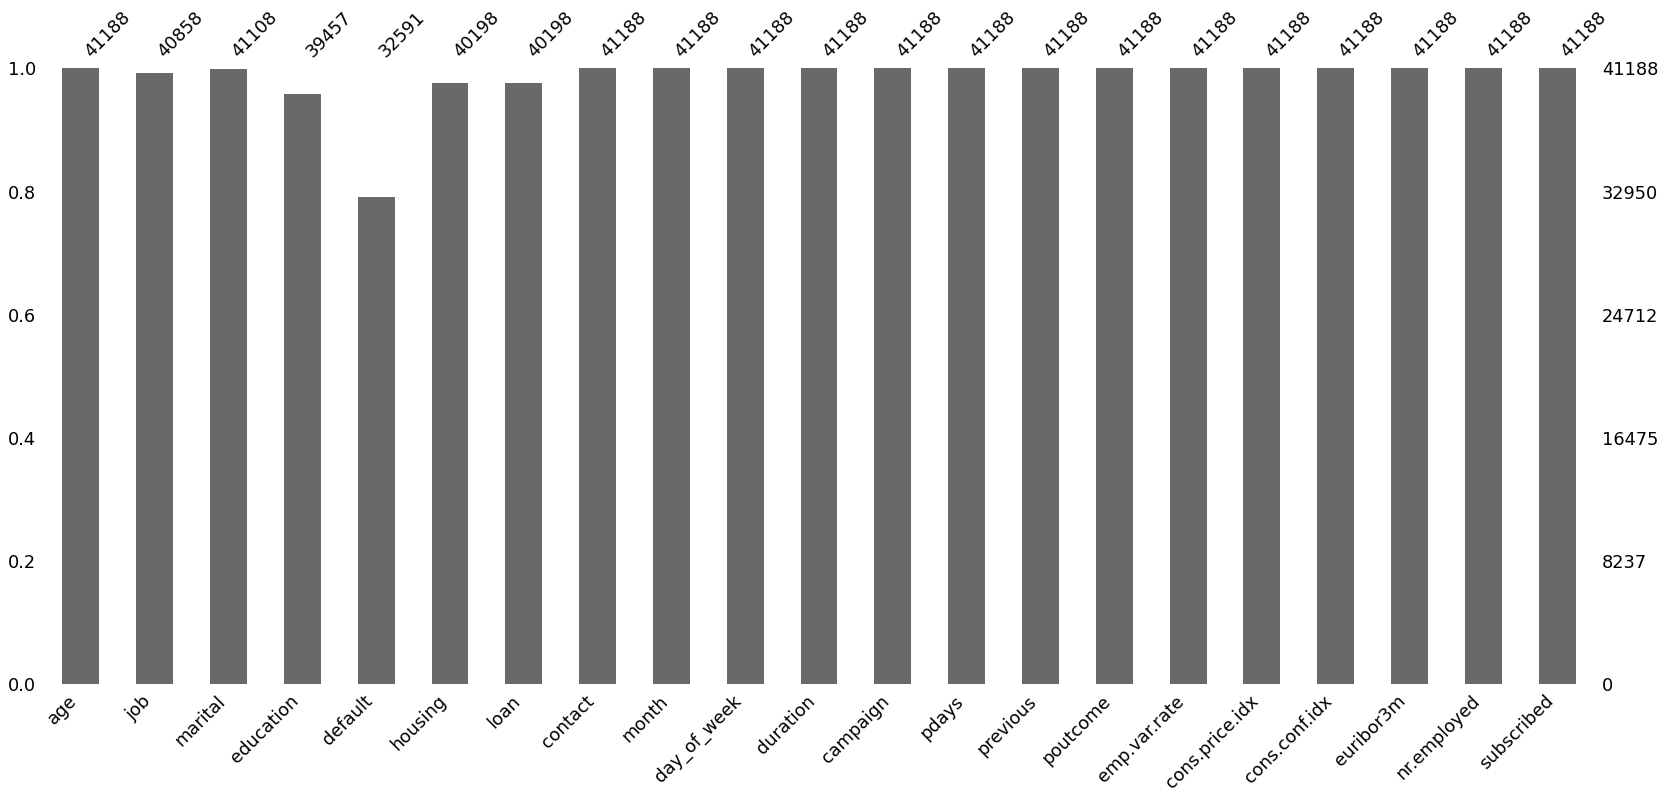

In [ ]:
msno.bar(df_procesado)

<Axes: >

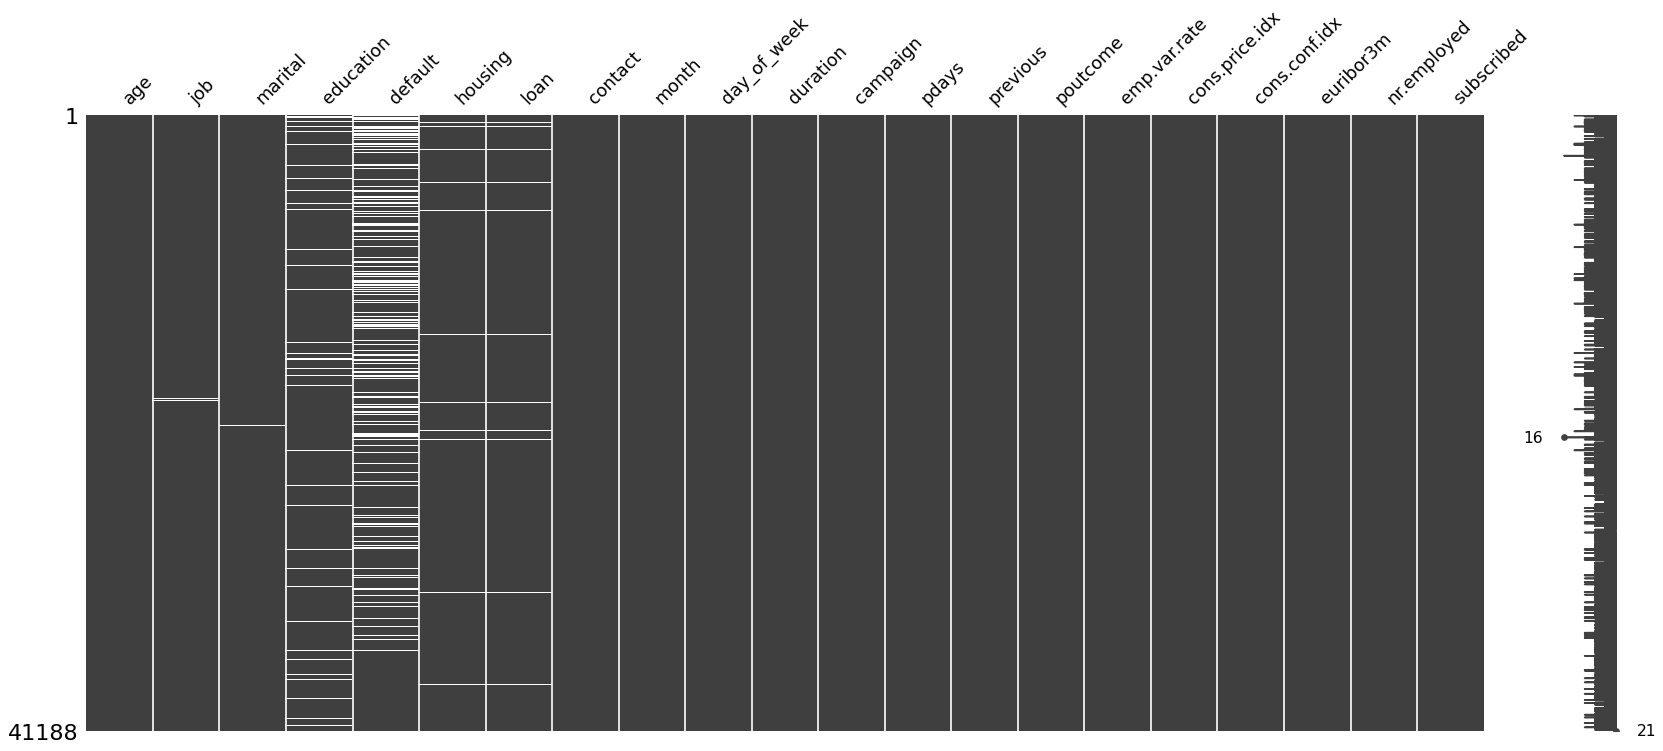

In [ ]:
msno.matrix(df_procesado)

Imputacion


In [ ]:
# variables a imputar por unknown para evitar generar ruido dado la sensivilidad de los datos categoricos
imputer = SimpleImputer(strategy='constant', fill_value='unknown')

df_procesado['poutcome'] = imputer.fit_transform(df_procesado[['poutcome']]).ravel()
df_procesado['default'] = imputer.fit_transform(df_procesado[['default']]).ravel()
df_procesado['loan'] = imputer.fit_transform(df_procesado[['loan']]).ravel()
df_procesado['housing'] = imputer.fit_transform(df_procesado[['housing']]).ravel()

In [ ]:
# selecciono las columnas a imputar por la moda dado que son columnas con datos categoricos no tan sensibles
# Imputación por la moda para la columna 'job'
imputer = SimpleImputer(strategy='most_frequent')
df_procesado['job'] = imputer.fit_transform(df_procesado[['job']]).ravel()
# Imputación por la moda para la columna 'marital'
df_procesado['marital'] = imputer.fit_transform(df_procesado[['marital']]).ravel()
# Imputación por la moda para la columna 'education'
df_procesado['education'] = imputer.fit_transform(df_procesado[['education']]).ravel()

<ipython-input-27-230af38deb05>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_procesado['contact'] = df_procesado['contact'].fillna(method='ffill')
<ipython-input-27-230af38deb05>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_procesado['contact'] = df_procesado['contact'].fillna(method='bfill')


In [ ]:
#Compruebo que la imputacion se realizo correctamente (en el caso de la columna contact pienso eliminarla luego)
df_procesado.isnull().sum().sum()

0

<Axes: >

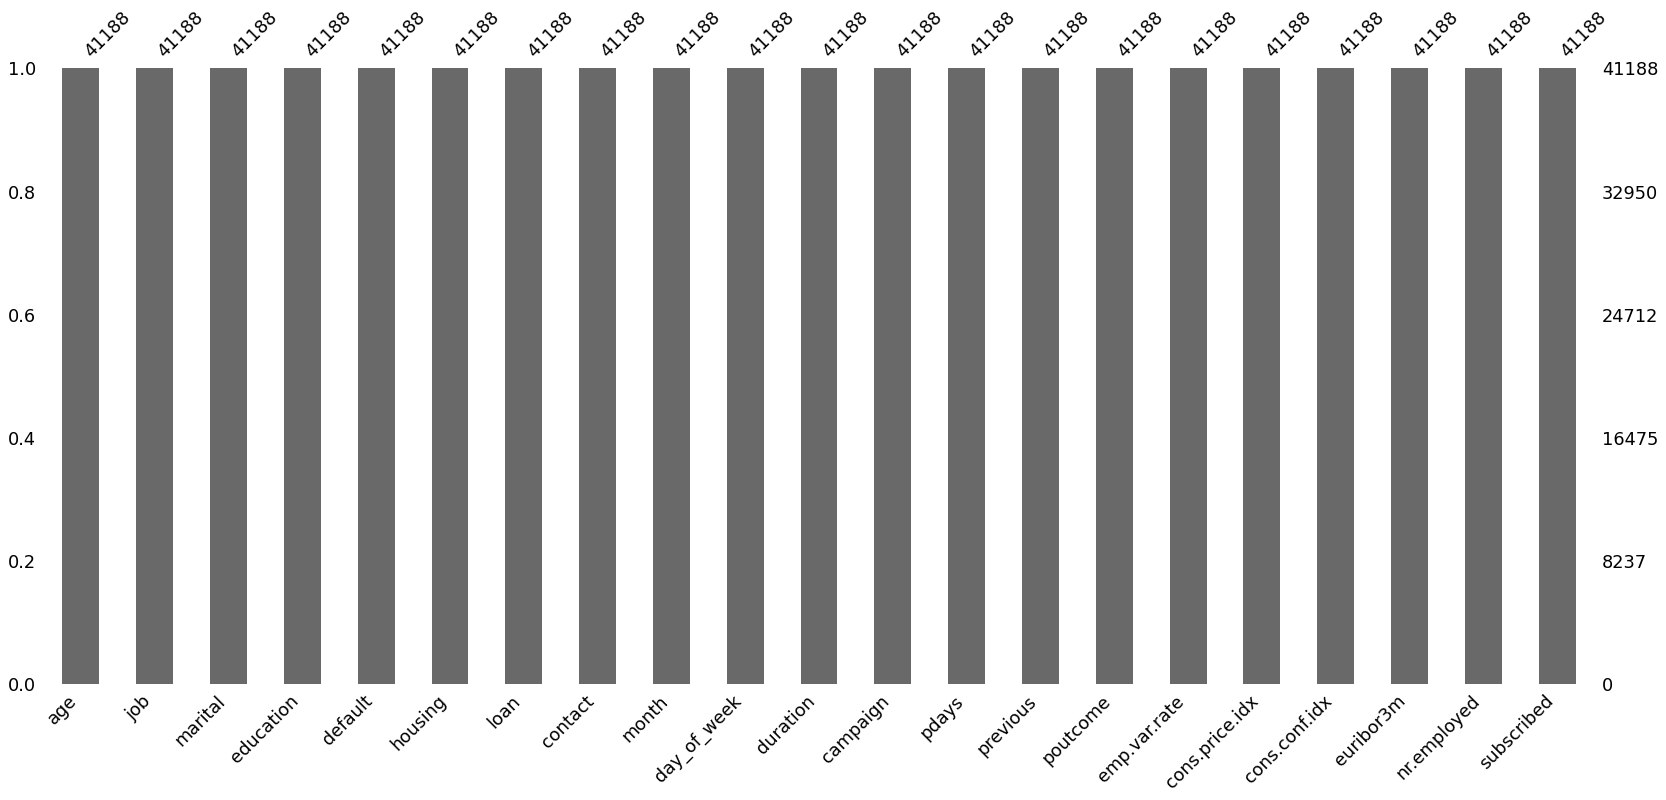

In [ ]:
msno.bar(df_procesado)

### Obvervacion de esta sub-etapa:

Los valores nulos están distribuidos de manera desigual entre las distintas columnas del conjunto de datos. Sin embargo, las columnas housing y loan presentan una correlación significativa en cuanto a la presencia de valores nulos. Esto es comprensible, ya que la falta de información sobre **el préstamo de vivienda (housing) frecuentemente coincide con la ausencia de datos sobre el préstamo personal (loan), lo que refleja la relación lógica entre estos dos atributos.**

## Ingenieria de caracteristicas

### Seleccion de caracteristicas

In [ ]:
df_procesado.sample(4)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
11836,41,entrepreneur,married,university.degree,unknown,yes,no,telephone,jun,fri,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
7850,30,services,married,high.school,no,no,no,telephone,jun,mon,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
37721,45,self-employed,married,university.degree,no,no,yes,cellular,aug,thu,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.851,5076.2,no
12016,35,self-employed,married,professional.course,unknown,yes,no,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.955,5228.1,no


In [ ]:
# Selecciono aquellas columnas que no aportan valor a la situacion de negocio

# contact: tipo de comunicación del contacto (categórico: ‘cellular’, ‘telephone’)
# pdays: número de días que han pasado desde que el cliente fue contactado por última vez en una campaña anterior (numérico; 999 significa que el cliente no fue contactado previamente)
# euribor3m: tasa euribor a 3 meses - indicador diario (numérico)
# nr.employed: número de empleados - indicador trimestral (numérico)
# duration: duración del último contacto, en segundos (numérico)

columnas_a_eliminar = ['contact', 'duration', 'pdays', 'nr.employed', 'euribor3m']
df_procesado.drop(columns=columnas_a_eliminar, inplace=True)

### Estandarizacion de tipos de datos

In [ ]:
df_procesado.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
month,object
day_of_week,object
campaign,int64


In [ ]:
# selecciono las columnas no numericas
columnas_no_numericas = df_procesado.select_dtypes(exclude=['number']).columns

# creo un diccionario con los valores unicos por columa y otro con la cantidad de valores unicos por columna
valores_unicos_por_columna = df_procesado[columnas_no_numericas].apply(lambda x: x.unique())
cantidad_valores_unicos_col = {col: len(valores_unicos_por_columna[col]) for col in valores_unicos_por_columna.index}

In [ ]:
print(valores_unicos_por_columna)

job            [housemaid, services, admin., blue-collar, tec...
marital                              [married, single, divorced]
education      [basic.4y, high.school, basic.6y, basic.9y, pr...
default                                       [no, unknown, yes]
housing                                       [no, yes, unknown]
loan                                          [no, yes, unknown]
month          [may, jun, jul, aug, oct, nov, dec, mar, apr, ...
day_of_week                            [mon, tue, wed, thu, fri]
poutcome                         [nonexistent, failure, success]
subscribed                                             [no, yes]
dtype: object


In [ ]:
valores_unicos_por_columna.index

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'month',
       'day_of_week', 'poutcome', 'subscribed'],
      dtype='object')

In [ ]:
print(cantidad_valores_unicos_col)

{'job': 11, 'marital': 3, 'education': 7, 'default': 3, 'housing': 3, 'loan': 3, 'month': 10, 'day_of_week': 5, 'poutcome': 3, 'subscribed': 2}


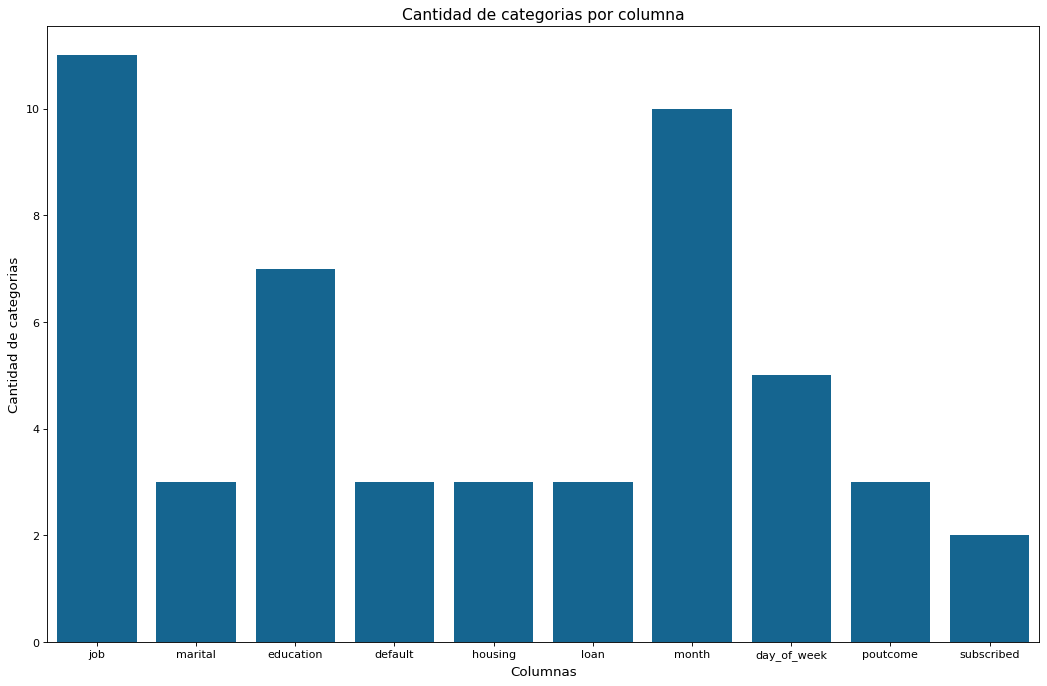

In [ ]:
sns.barplot(data=cantidad_valores_unicos_col)
plt.title('Cantidad de categorias por columna')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de categorias')
plt.show()

In [ ]:
# separo dos listas para las variables categoricas, uno con las nominales y otro con las ordinales
columnas_categoricas_ordinales = ['marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome', 'subscribed']
columnas_categoricas_nominales = ['job']
# creo una lista que unifica las variables categoricas ordinales y nominales dentro de una sola
columnas_categoricas = columnas_categoricas_ordinales + columnas_categoricas_nominales

In [ ]:
# transformo el tipo de datos de las columnas categoricas a 'category'
df_procesado[columnas_categoricas] = df_procesado[columnas_categoricas].astype('category')

In [ ]:
# transformo el tipo de dato de la columna "month" a su correspondiente
df_procesado['month'] = pd.to_datetime(df_procesado['month'], format='%b').dt.month

### Codificacion de datos

Variables categoricas ordinales

In [ ]:
df_variables_ordinales_escaladas = pd.DataFrame({})

In [ ]:
# Definir un diccionario con las categorías en orden
categorias_ordenadas = {
    'marital': ['unknown', 'single', 'married', 'divorced'],
    'education': [np.nan, 'unknown', 'basic.4y', 'basic.6y', 'basic.9y', 'primary', 'high.school', 'secondary', 'illiterate', 'professional.course', 'tertiary', 'university.degree'],
    'default': ['unknown', 'no', 'yes'],
    'housing': ['unknown', 'no', 'yes'],
    'loan': ['unknown', 'no', 'yes'],
    'poutcome': [np.nan, 'other', 'failure', 'nonexistent', 'success'],
    'subscribed': ['no', 'yes'],
    'month': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
}

# Configurar el codificador con las categorías en el orden especificado
ordinal_encoder = OrdinalEncoder(categories=list(categorias_ordenadas.values()))

# Aplicar el codificador a las columnas y asignar los resultados a nuevas columnas
columnas_codificadas = [f"{col}_encoded" for col in categorias_ordenadas.keys()]
df_variables_ordinales_escaladas[columnas_codificadas] = ordinal_encoder.fit_transform(df_procesado[list(categorias_ordenadas.keys())])

In [ ]:
df_variables_ordinales_escaladas.sample(2)

,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,poutcome_encoded,subscribed_encoded,month_encoded
23349,2.0,9.0,1.0,1.0,1.0,3.0,0.0,7.0
9742,2.0,11.0,1.0,1.0,1.0,3.0,0.0,5.0


Variables categoricas nominales

In [ ]:
df_variables_nominales_escaladas = pd.DataFrame({}, columns=columnas_categoricas_nominales)

In [ ]:
# Inicializar el codificador
label_encoders = {col: LabelEncoder() for col in columnas_categoricas_nominales}

# Aplicar el codificador a las columnas nominales
for col in columnas_categoricas_nominales:
    df_variables_nominales_escaladas[col] = label_encoders[col].fit_transform(df_procesado[col])

In [ ]:
df_variables_nominales_escaladas.sample(2)

,job
13822,0
8975,0


### Escalamiento de datos

In [ ]:
df_columnas_numericas = df_procesado.select_dtypes(include=['number'])

In [ ]:
# Escalar las variables numéricas
scaler = RobustScaler()
variables_numericas_escaladas = scaler.fit_transform(df_columnas_numericas)
df_numerico_escalado = pd.DataFrame(variables_numericas_escaladas, columns=df_columnas_numericas.columns)

In [ ]:
# Concatenar los DataFrames
df_estandarizado_escalado = pd.concat([df_numerico_escalado, df_variables_ordinales_escaladas, df_variables_nominales_escaladas], axis=1)

# Crear el diccionario de renombramiento
nombres_actuales = df_estandarizado_escalado.columns
nuevos_nombres = (df_numerico_escalado.columns.tolist() +
                   df_variables_ordinales_escaladas.columns.tolist() +
                   df_variables_nominales_escaladas.columns.tolist())
renombramiento = dict(zip(nombres_actuales, nuevos_nombres))

df_estandarizado_escalado.rename(columns=renombramiento, inplace=True)

In [ ]:
df_estandarizado_escalado.sample(2)

,age,month,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,poutcome_encoded,subscribed_encoded,month_encoded,job
18007,0.266667,0.333333,2.0,0.0,0.09375,0.183896,-0.142857,2.0,6.0,1.0,1.0,1.0,3.0,0.0,6.0,0
38478,-0.800000,1.333333,-0.5,0.0,-1.40625,-1.434168,2.365079,2.0,6.0,1.0,2.0,1.0,3.0,1.0,9.0,0


### Guardado de datos procesados

In [ ]:
# guardo los dataframes procesados y escalados en la carpeta "silver"
path_df_procesado = '/content/data/silver/df_procesado.csv'
df_procesado.to_csv(path_df_procesado, index=False)

path_csv_estandarizado_escalado = '/content/data/silver/df_estandarizado_escalado.csv'
df_estandarizado_escalado.to_csv(path_csv_estandarizado_escalado, index=False)

# EDA

### Correlacion entre variables

Pairplot

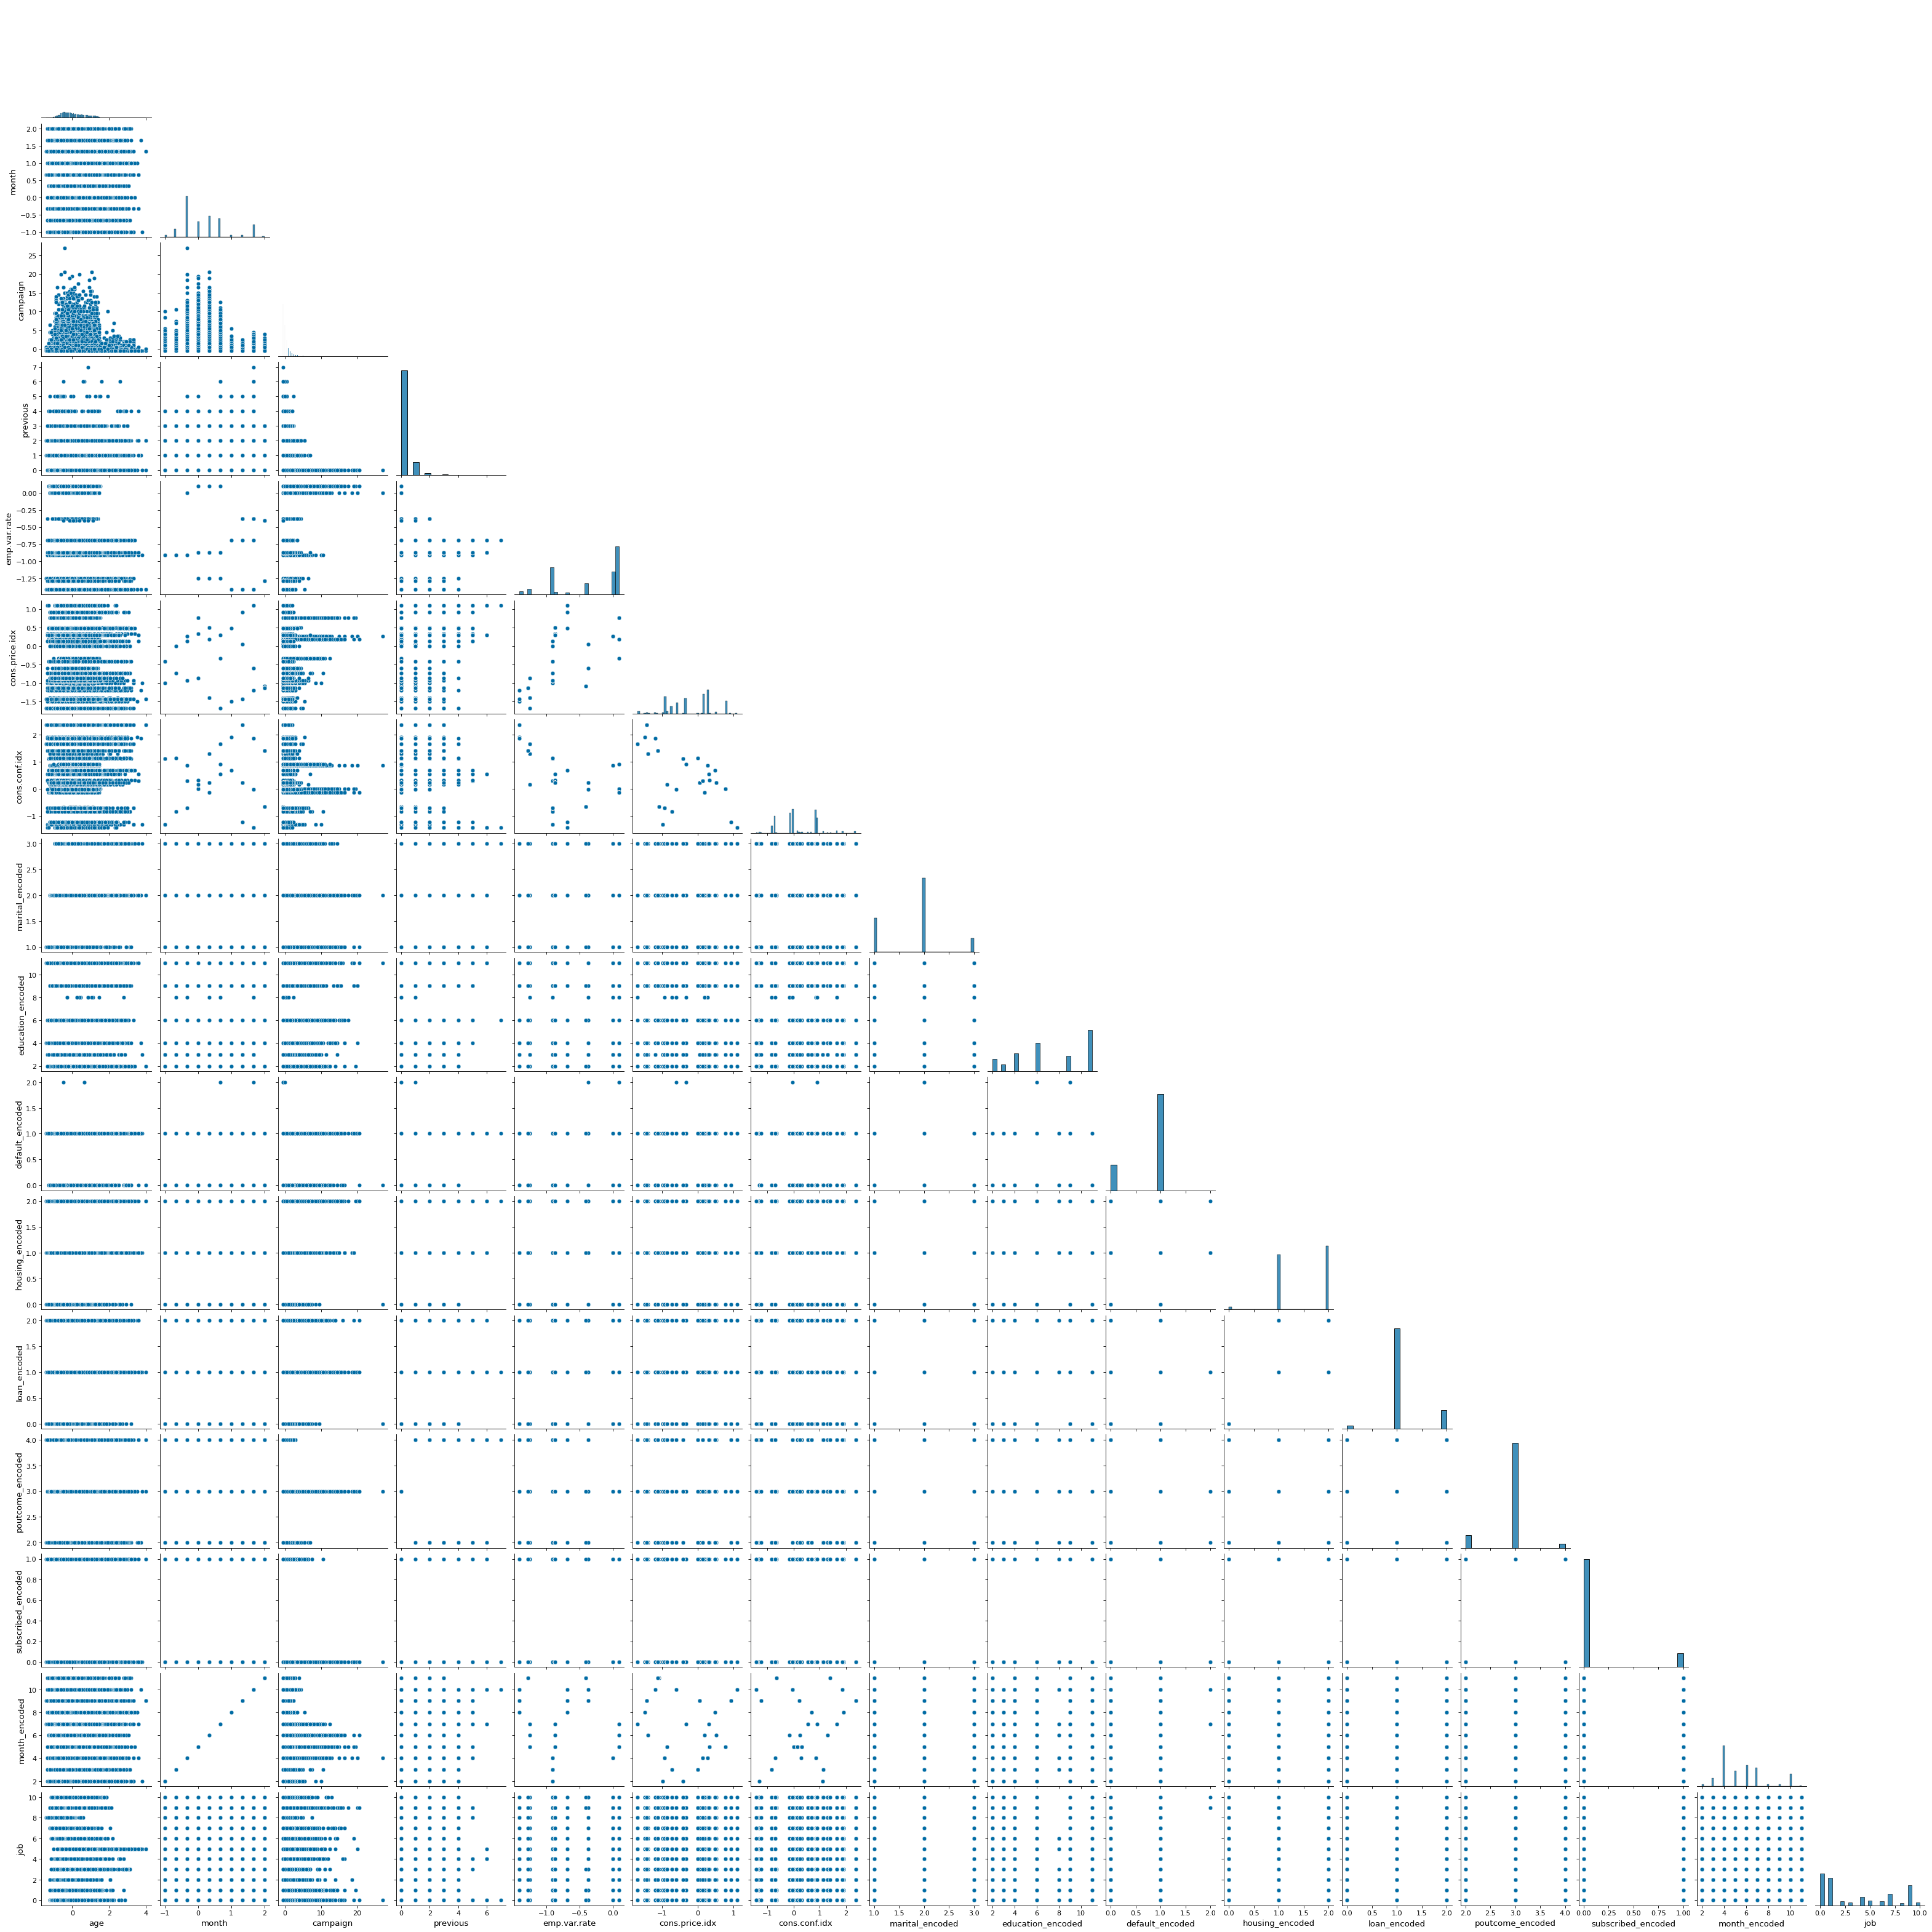

In [ ]:
sns.pairplot(data=df_estandarizado_escalado, corner=True)

Matriz de correlacion

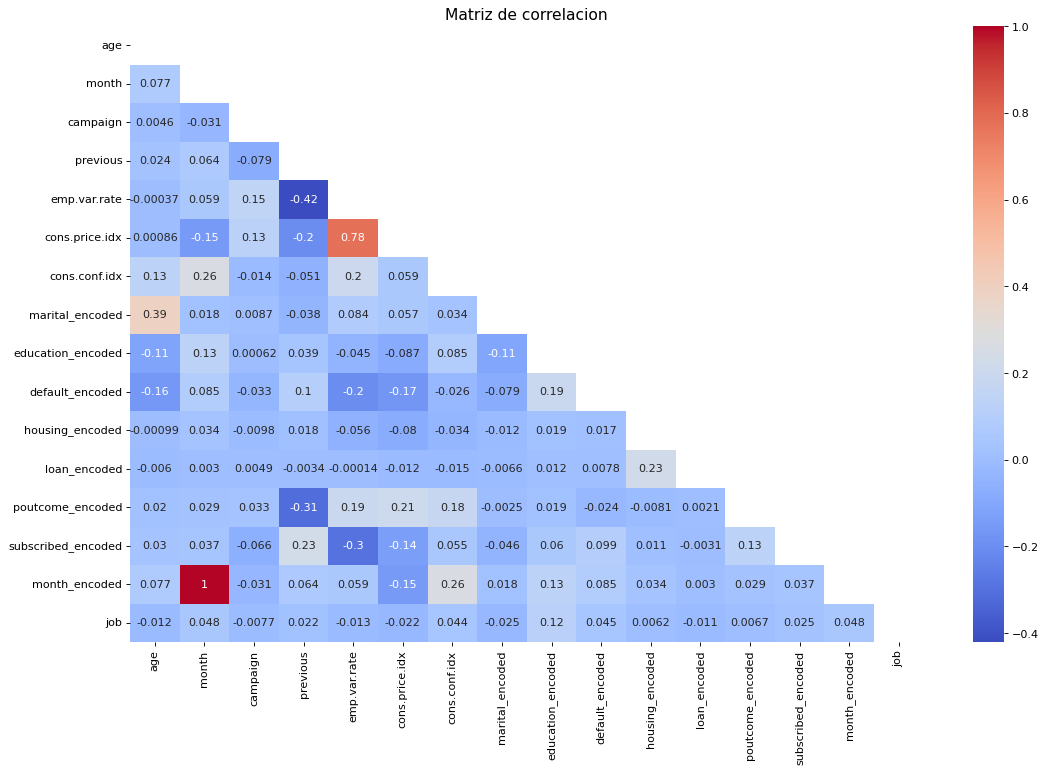

In [ ]:
# creo una matriz de correlacion traingular, eliminando la parte espejo por mdeio de una mask creada con mumpy
matriz_corr = df_estandarizado_escalado.corr()
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
sns.heatmap(data=matriz_corr, mask = mask, annot=True, cmap='coolwarm')
plt.title('Matriz de correlacion')
plt.show()

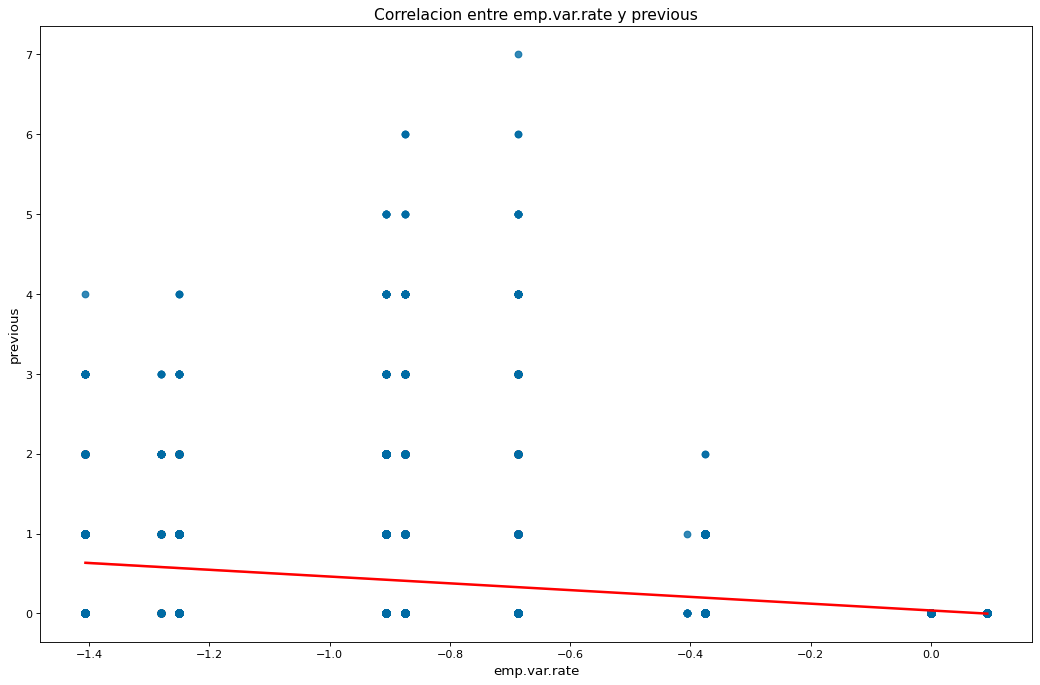

In [ ]:
sns.regplot(data=df_estandarizado_escalado, x='emp.var.rate', y='previous', line_kws={'color':'r'})
plt.title('Correlacion entre emp.var.rate y previous')
plt.xlabel('emp.var.rate')
plt.ylabel('previous')
plt.show()

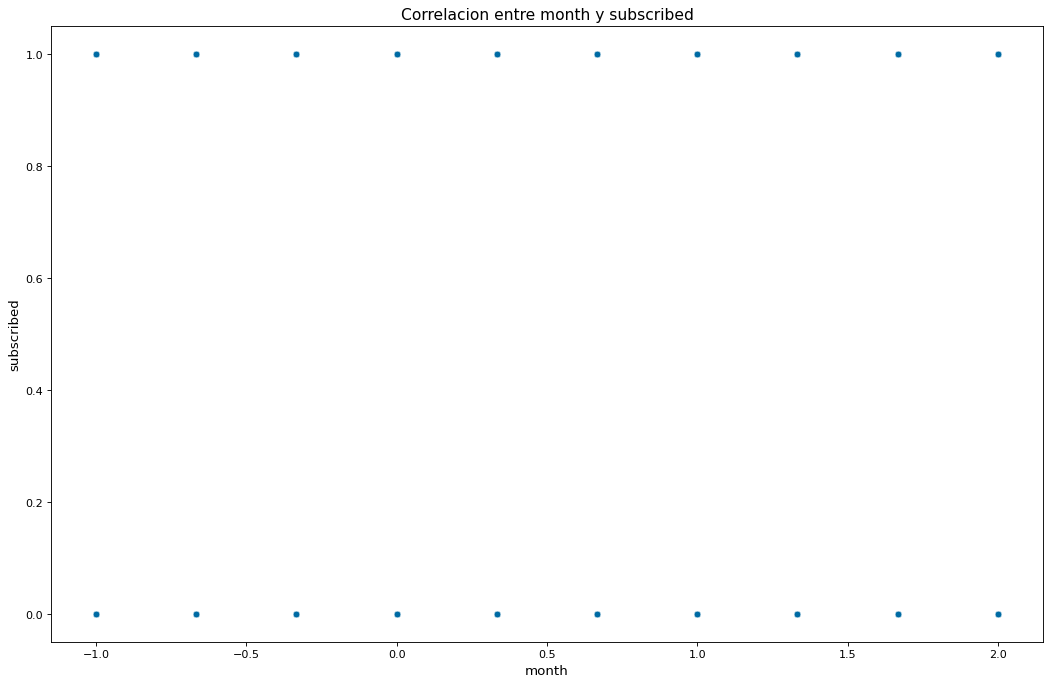

In [ ]:
sns.scatterplot(data=df_estandarizado_escalado, x='month', y='subscribed_encoded')
plt.title('Correlacion entre month y subscribed')
plt.xlabel('month')
plt.ylabel('subscribed')
plt.show()

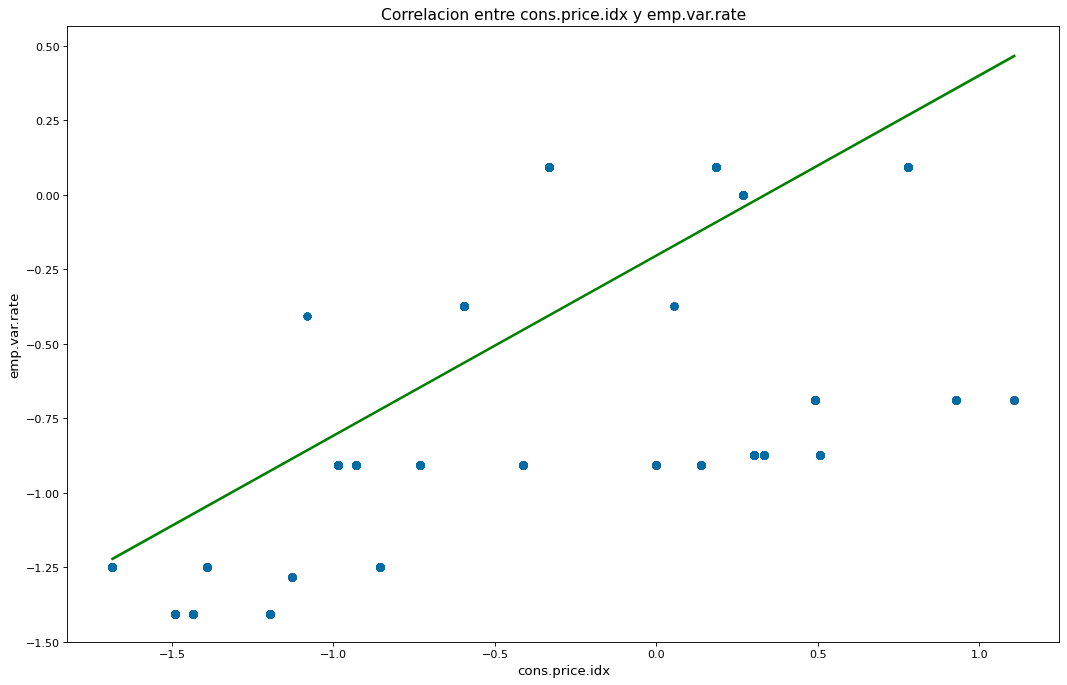

In [ ]:
sns.regplot(data=df_estandarizado_escalado, x='cons.price.idx', y='emp.var.rate', line_kws={'color':'g'})
plt.title('Correlacion entre cons.price.idx y emp.var.rate')
plt.xlabel('cons.price.idx')
plt.ylabel('emp.var.rate')
plt.show()

**Observacion de correlaciones lineales significativas**
- **cons.price.idx - emp.var.rate: Correlacion lineal fuerte y positiva del 0.78**
- emp.var.rate - previous: Correlacion lineal negativa y debil del -0.42

**Observacion de correlaciones lineales con la variable target (subscribed):**
- subscribed - previous: Correlacion lineal debil y positiva del 0.23
- subscribed - emp.var.rate: Correlacion lineal debil y negativa del -0.3

### Perfil socio-economico de los clientes

In [ ]:
# Creo un dataframe exclusivo para aquellos registros que pertenecen a las personas adheridas al servicio
df_clientes = df_procesado[df_procesado['subscribed'] == 'yes'].copy()

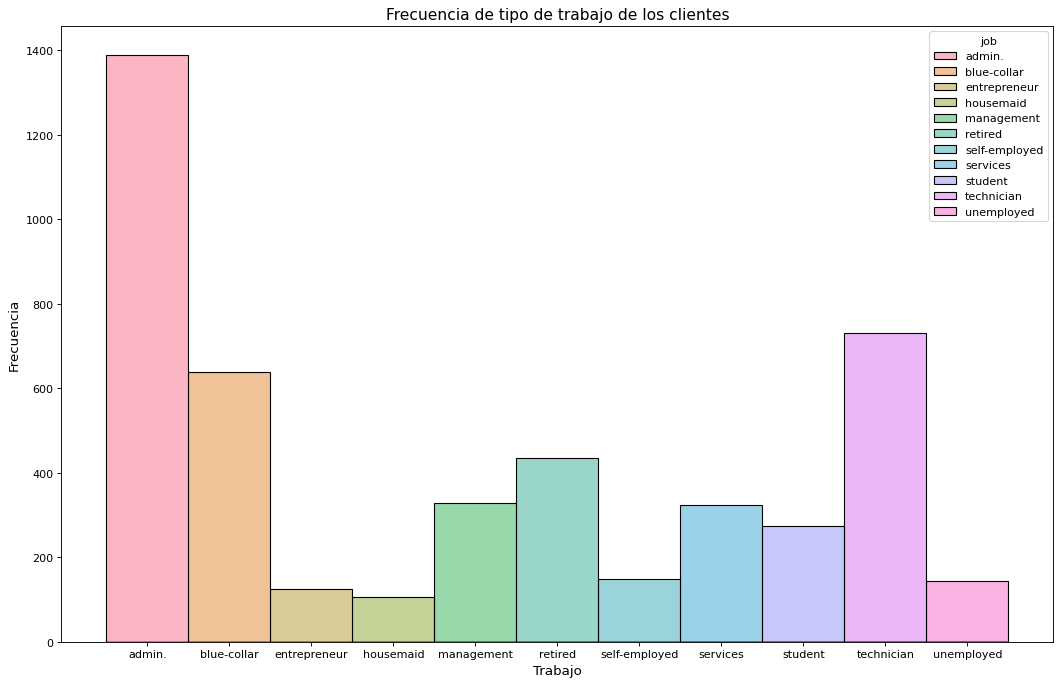

In [ ]:
sns.histplot(data=df_clientes, x='job', hue='job')
plt.title('Frecuencia de tipo de trabajo de los clientes')
plt.xlabel('Trabajo')
plt.ylabel('Frecuencia')
plt.show()

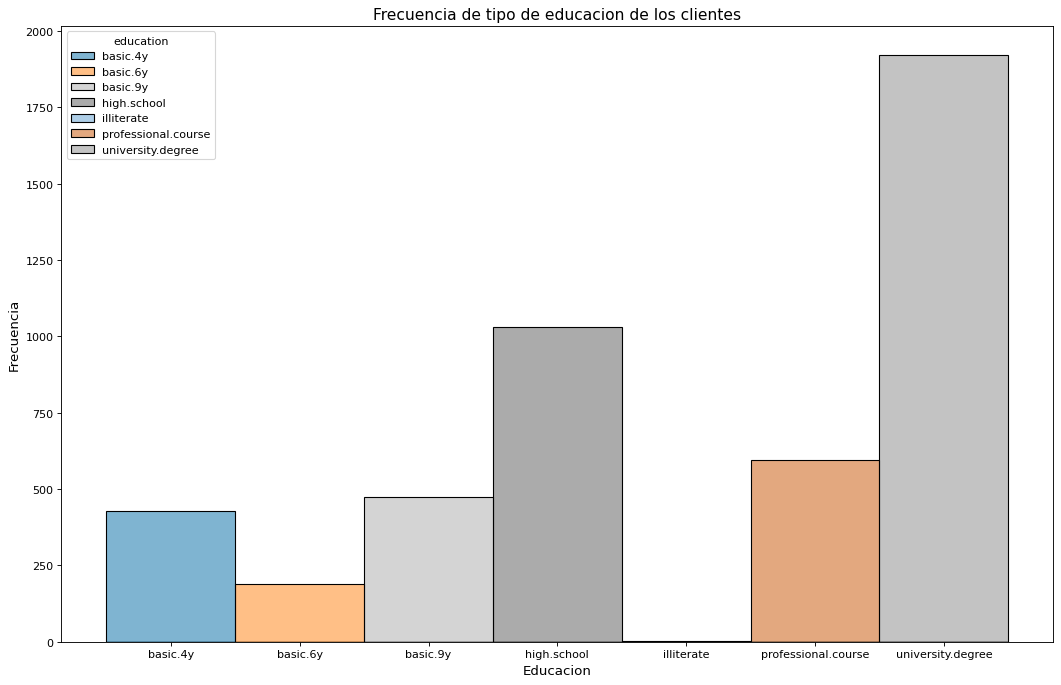

In [ ]:
sns.histplot(data=df_clientes, x='education', hue='education')
plt.title('Frecuencia de tipo de educacion de los clientes')
plt.xlabel('Educacion')
plt.ylabel('Frecuencia')
plt.show()

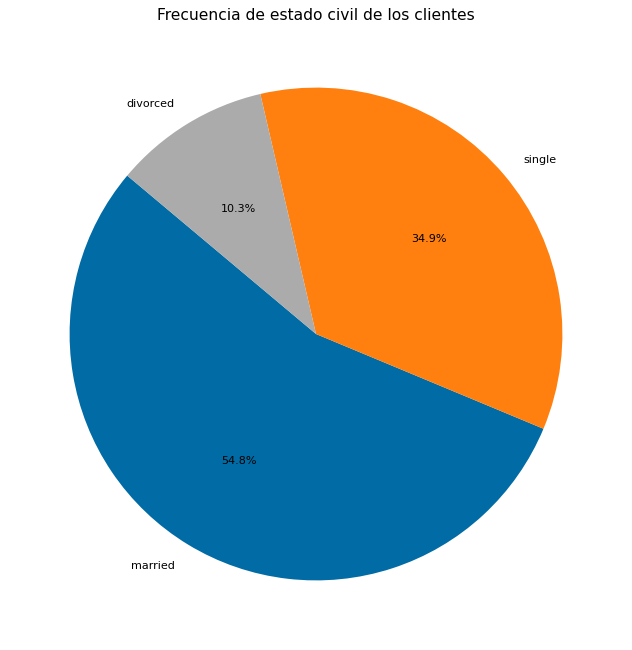

In [ ]:
estado_matrimonial_counts = df_clientes['marital'].value_counts()

plt.pie(estado_matrimonial_counts,labels=estado_matrimonial_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Frecuencia de estado civil de los clientes')
plt.show()

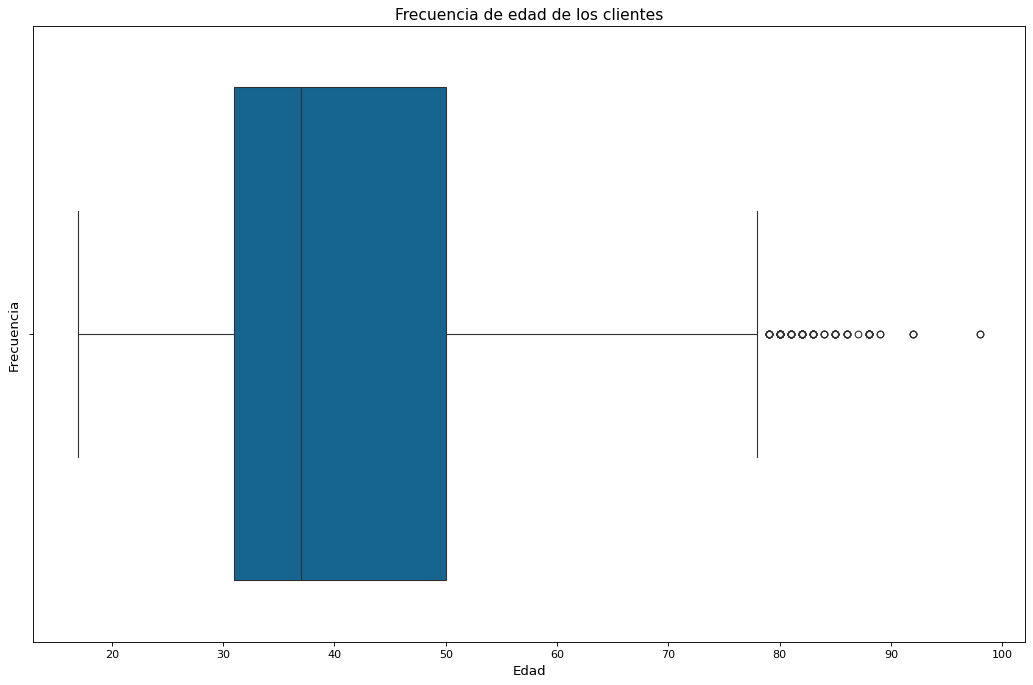

In [ ]:
sns.boxplot(data=df_clientes, x='age')
plt.title('Frecuencia de edad de los clientes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Al examinar las variables educación y empleo, se puede inferir que las **personas que se suscriben al servicio de depósito** de este banco parecen tener un **perfil socioeconómico de clase media**. Las cinco principales categorías de empleo entre los suscriptores son: **administrativos, técnicos, obreros**, retirados y de gestión. En cuanto a los niveles educativos, las categorías predominantes son **universitario, secundaria y cursos profesionales**. Además, se observa que la mayoría de los suscriptores tienen **entre 30 y 50 años de edad**. En términos de **estado civil, el 50.8% de los suscriptores están casados, mientras que un considerable 34.9% son solteros.**

### Analisis de suscripcion

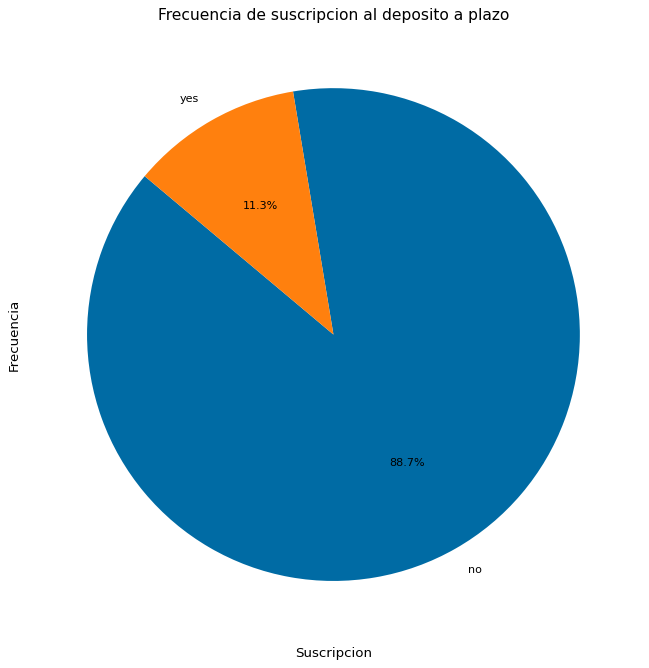

In [ ]:
subscribed_counts = df_procesado['subscribed'].value_counts()

plt.pie( subscribed_counts,labels=subscribed_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Frecuencia de suscripcion al deposito a plazo')
plt.xlabel('Suscripcion')
plt.ylabel('Frecuencia')
plt.show()

La mayoría de las personas contactadas, un **88.7%, no se suscriben** al servicio de depósito tras la llamada, mientras que solo el **11.3% restante muestra adherencia al servicio.**


### Guardado de dataset de BI

In [ ]:
# guardo el dataset con info exclusiva de los clientes en la carpeta de 'gold'
path_dataset_bi = '/content/data/gold/df_procesado.csv'
df_clientes.to_csv(path_dataset_bi, index=False)